In [1]:
import nltk
import json

In [2]:
file_d = []
reviews_sent = []
reviews_neg_sent = []
reviews_str = ""

In [3]:
file = '/Users/gkhanna/Downloads/reviews_Home_and_Kitchen_5.json'

In [4]:
# Reading count number of JSON lines from the file
count = 5000
n = 0
with open(file, "r") as f:
    for line in f:
        file_d.append(json.loads(line))
        n =  n + 1
        if n == count:
            break
    


In [5]:
# Checking the structures
print(len(file_d))
print(type(file_d))
print(file_d[0])
print(type(file_d[0]))

5000
<class 'list'>
{'reviewerID': 'APYOBQE6M18AA', 'asin': '0615391206', 'reviewerName': 'Martin Schwartz', 'helpful': [0, 0], 'reviewText': 'My daughter wanted this book and the price on Amazon was the best.  She has already tried one recipe a day after receiving the book.  She seems happy with it.', 'overall': 5.0, 'summary': 'Best Price', 'unixReviewTime': 1382140800, 'reviewTime': '10 19, 2013'}
<class 'dict'>


In [6]:
print(file_d[0]['reviewText'])

My daughter wanted this book and the price on Amazon was the best.  She has already tried one recipe a day after receiving the book.  She seems happy with it.


In [7]:
# Getting the reviews out of the dictionary
# into a list and string
for r in file_d:
    reviews_sent.append(r['reviewText'])
    reviews_str = reviews_str + str(r['reviewText'])

In [8]:
print(type(reviews_sent))
print(len(reviews_sent))
print(reviews_sent[0])

<class 'list'>
5000
My daughter wanted this book and the price on Amazon was the best.  She has already tried one recipe a day after receiving the book.  She seems happy with it.


In [9]:
len(reviews_str)

2114261

In [10]:
print(reviews_str[:30])

My daughter wanted this book a


Tokenize the sentences in the full review
PunktSentenceTokenizer is customized to separate sentences on a few extra words and characters as well

In [11]:
from nltk.tokenize.punkt import PunktSentenceTokenizer, PunktLanguageVars
'''We customize the ReviewLangVars class to separate sentences based on some additional keywords'''


class ReviewLangVars(PunktLanguageVars):
    sent_end_chars = ('pros:', 'cons:', '[','][','.','?','!')
    
sent_tokenizer1 = PunktSentenceTokenizer(lang_vars = ReviewLangVars())
# sent_tokenizer1 = PunktSentenceTokenizer()
sent_fullreview = sent_tokenizer1.tokenize(reviews_str)

In [12]:
# This are the original sentences tokenized
print(sent_fullreview[0])
print(sent_fullreview[:5])
len(sent_fullreview)

My daughter wanted this book and the price on Amazon was the best.
['My daughter wanted this book and the price on Amazon was the best.', 'She has already tried one recipe a day after receiving the book.', 'She seems happy with it.I bought this zoku quick pop for my daughterr with her zoku quick maker.', 'She loves it and have fun to make her own ice cream.There is no shortage of pop recipes available for free on the web, but I purchased the "Zoku Quick Pops" book, because Zoku has some good recipes for fruit pops on its blog.', 'I was hoping there were more where those came from.']


19404

Extracting common features using apriori
https://github.com/asaini/Apriori

In [13]:
import sys

from itertools import chain, combinations
from collections import defaultdict
from optparse import OptionParser


def subsets(arr):
    """ Returns non empty subsets of arr"""
    return chain(*[combinations(arr, i + 1) for i, a in enumerate(arr)])


def returnItemsWithMinSupport(itemSet, transactionList, minSupport, freqSet):
        """calculates the support for items in the itemSet and returns a subset
       of the itemSet each of whose elements satisfies the minimum support"""
        _itemSet = set()
        localSet = defaultdict(int)

        for item in itemSet:
                for transaction in transactionList:
                        if item.issubset(transaction):
                                freqSet[item] += 1
                                localSet[item] += 1

        for item, count in localSet.items():
                support = float(count)/len(transactionList)

                if support >= minSupport:
                        _itemSet.add(item)

        return _itemSet


def joinSet(itemSet, length):
        """Join a set with itself and returns the n-element itemsets"""
        return set([i.union(j) for i in itemSet for j in itemSet if len(i.union(j)) == length])


def getItemSetTransactionList(data_iterator):
    transactionList = list()
    itemSet = set()
    for record in data_iterator:
        transaction = frozenset(record)
        transactionList.append(transaction)
        for item in transaction:
            itemSet.add(frozenset([item]))              # Generate 1-itemSets
    return itemSet, transactionList


def runApriori(data_iter, minSupport, minConfidence):
    """
    run the apriori algorithm. data_iter is a record iterator
    Return both:
     - items (tuple, support)
     - rules ((pretuple, posttuple), confidence)
    """
    itemSet, transactionList = getItemSetTransactionList(data_iter)

    freqSet = defaultdict(int)
    largeSet = dict()
    # Global dictionary which stores (key=n-itemSets,value=support)
    # which satisfy minSupport

    assocRules = dict()
    # Dictionary which stores Association Rules

    oneCSet = returnItemsWithMinSupport(itemSet,
                                        transactionList,
                                        minSupport,
                                        freqSet)

    currentLSet = oneCSet
    k = 2
    while(currentLSet != set([])):
        largeSet[k-1] = currentLSet
        currentLSet = joinSet(currentLSet, k)
        currentCSet = returnItemsWithMinSupport(currentLSet,
                                                transactionList,
                                                minSupport,
                                                freqSet)
        currentLSet = currentCSet
        k = k + 1

    def getSupport(item):
            """local function which Returns the support of an item"""
            return float(freqSet[item])/len(transactionList)

    toRetItems = []
    for key, value in list(largeSet.items()):
        toRetItems.extend([(tuple(item), getSupport(item))
                           for item in value])

    toRetRules = []
    for key, value in list(largeSet.items())[1:]:
        for item in value:
            _subsets = map(frozenset, [x for x in subsets(item)])
            for element in _subsets:
                remain = item.difference(element)
                if len(remain) > 0:
                    confidence = getSupport(item)/getSupport(element)
                    if confidence >= minConfidence:
                        toRetRules.append(((tuple(element), tuple(remain)),
                                           confidence))
    return toRetItems, toRetRules


def printResults(items):
    """prints the generated itemsets sorted by support and the confidence rules sorted by confidence"""
    for item, support in sorted(items, key=lambda item_support: item_support[1], reverse=True):
        print(str(item), support)

In [14]:
# Utility functions
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

lem = nltk.WordNetLemmatizer()
stemmer = nltk.stem.porter.PorterStemmer()
lem_word_mapping = {}

# Find leaves of a tree
def leaves(tree):
    """Finds leaf nodes of a chunk tree."""
    for subtree in tree.subtrees(filter = lambda t: t.label() in ['P1','P2','P3','P4','P5','P6','P7','P8']):
        yield subtree.leaves()
    
def stem(word):
    """Normalises words to lowercase and stems and lemmatizes it."""
    word = word.lower()
    word = word.replace("'","").replace('"','').replace('.','')
    word1 = stemmer.stem(word)
    return word1

# lowercase, stem and lemmatize
def normalise(word):
    """Normalises words to lowercase and stems and lemmatizes it."""
    word = word.lower()
    word1 = stemmer.stem(word)
    word2 = lem.lemmatize(word1)
    if word != word2:
        lem_word_mapping[word2] = word
    return word2

def acceptableWord(word):
    """Checks conditions for acceptable word: length, stopword."""
    accepted = bool((2 <= len(word) <= 40) and word.lower() not in stopwords)
    return accepted

# extract words after normalizing and checking if acceptable
def getTerms(tree):
    """Returns the words after checking acceptable conditions, normalizing and lemmatizing"""
    term = [ stem(w) for w in tree if acceptableWord(w) ]
    return term
    
def getNorm(tree):
    """Parse leaves in chunk and return after checking acceptable conditions, normalizing and lemmatizing"""
    for leaf in leaves(tree):
        term = [ normalise(w) for w,t in leaf if acceptableWord(w) ]
        yield term

Set of nouns for each sentence

In [15]:
# Set of nouns for the apriori algorithm

def isNoun(n):
    if n=='NN' or n=='NNS' or n=='NNP' or n=='NNPS':
        return True

revset=[]
for line in sent_fullreview:
    # print(line)
    a = nltk.word_tokenize(line)
    # print(a)
    nouns = [word for (word, pos) in nltk.pos_tag(a) if isNoun(pos)] 
    # print(nouns)
    terms = getTerms(nouns)
    # print(terms)

    revset.append(terms)



In [16]:
print(revset[0])
print(revset[:10])

['daughter', 'book', 'price', 'amazon']
[['daughter', 'book', 'price', 'amazon'], ['recip', 'day', 'book'], ['zoku', 'pop', 'daughterr', 'zoku', 'quick', 'maker'], ['fun', 'ice', 'shortag', 'pop', 'recip', 'web', 'zoku', 'quick', 'pop', 'book', 'zoku', 'recip', 'fruit', 'pop', 'blog'], [], ['book', 'dessert', 'pop'], ['recip', 'total', 'pop'], ['fresh', 'fruiti', 'chapter', 'chapter', 'pop', 'quick', 'pop'], ['shop', 'coco', 'loco'], ['recip', 'chocolatechapt', 'tip', 'techniqu']]


In [17]:
len(revset)

19404

Below are the most common features in the reviews

In [18]:
items, rules = runApriori(revset, 0.01, 0.05)
printResults(items)

('oxo',) 0.06029684601113173
('time',) 0.05483405483405483
('product',) 0.04916512059369202
('handl',) 0.0489589775304061
('year',) 0.045763760049474335
('hand',) 0.04086786229643372
('ice',) 0.039888682745825604
('cream',) 0.03849721706864564
('thing',) 0.03318903318903319
('ice', 'cream') 0.03303442589156875
('bowl',) 0.03282828282828283
('grip',) 0.03190063904349619
('use',) 0.031230674087816945
('kitchen',) 0.0292723149866007
('potato',) 0.026128633271490415
('lot',) 0.02463409606266749
('one',) 0.02432488146773861
('size',) 0.02406720263863121
('job',) 0.023809523809523808
('fan',) 0.02298495155638013
('brush',) 0.022314986600700887
('qualiti',) 0.021645021645021644
('pressur',) 0.02061430632859204
('tool',) 0.020459699031127602
('item',) 0.019995877138734283
('spinner',) 0.01984126984126984
('bit',) 0.018810554524840237
('cooker',) 0.018810554524840237
('review',) 0.01870748299319728
('way',) 0.01860441146155432
('food',) 0.01850133992991136
('price',) 0.018243661100803957
('vacu

In [24]:
# Convert into tokens/words
all_sen_tok = []
for sentence in sent_fullreview:
    all_sen_tok.append(nltk.word_tokenize(sentence))

In [25]:
print(all_sen_tok[0])
print(all_sen_tok[:2])

['My', 'daughter', 'wanted', 'this', 'book', 'and', 'the', 'price', 'on', 'Amazon', 'was', 'the', 'best', '.']
[['My', 'daughter', 'wanted', 'this', 'book', 'and', 'the', 'price', 'on', 'Amazon', 'was', 'the', 'best', '.'], ['She', 'has', 'already', 'tried', 'one', 'recipe', 'a', 'day', 'after', 'receiving', 'the', 'book', '.']]


In [23]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/gkhanna/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [26]:
# Gave an error without downloading the nltk averaged_perceptron_tagger
# Find POS tags to the tokens
all_sen_tok_tagged = []
for sentence_t in all_sen_tok:
    all_sen_tok_tagged.append(nltk.tag.pos_tag(sentence_t))

In [27]:
print(all_sen_tok_tagged[0])

[('My', 'PRP$'), ('daughter', 'NN'), ('wanted', 'VBD'), ('this', 'DT'), ('book', 'NN'), ('and', 'CC'), ('the', 'DT'), ('price', 'NN'), ('on', 'IN'), ('Amazon', 'NNP'), ('was', 'VBD'), ('the', 'DT'), ('best', 'JJS'), ('.', '.')]


Extract phrases that talk about features and associated sentiment/opinion

In [28]:
# Patterns that we want to extract
# We think these are the ones that contain features
feature_patterns = r"""       
    P1:{<JJ><NN|NNS>}
    P2:{<JJ><NN|NNS><NN|NNS>}
    P3:{<RB|RBR|RBS><JJ>}
    P4:{<RB|RBR|RBS><JJ|RB|RBR|RBS><NN|NNS>}
    P5:{<RB|RBR|RBS><VBN|VBD>}
    P6:{<RB|RBR|RBS><RB|RBR|RBS><JJ>}
    P7:{<VBN|VBD><NN|NNS>}
    P8:{<VBN|VBD><RB|RBR|RBS>}
"""

Extract common features using apriori algorithm

In [29]:
len(revset)

19404

Utility functions

In [30]:
def getTerms1(tree):
    """Returns the words after checking acceptable conditions, normalizing and lemmatizing"""
    term = [ normalise(w) for w in tree if acceptable_word(w) ]
    yield term

In [33]:
# Extract feature phrases with ngram rules
def extractFeaturePhrases(tagged):
    out = []
    for phrase in tagged:
        r_parser = nltk.RegexpParser(feature_patterns)
        chunk_2 = r_parser.parse(phrase)
        term = getNorm(chunk_2)
        
        for ter in term:
            word_concat = ""
            for word in ter:
                word_concat = word_concat + " " + word
                
            if (len(ter) > 1):
                out.append(word_concat)
        
    return out

extracted = extractFeaturePhrases(all_sen_tok_tagged)
        

In [34]:
print(extracted[:10])

[' alreadi tri', ' quick pop', ' good recip', ' sweet dessert', ' fruit pop', ' dessert pop', ' pop recip', ' detail inform', ' differ type', ' decor fruit']


Find out the most common ones, frequency distribution

In [35]:
freqdist = nltk.FreqDist(word for word in extracted)

In [36]:
type(freqdist)

nltk.probability.FreqDist

In [68]:
most_common = freqdist.most_common()
print(most_common[:10])

[(' well made', 148), (' salad spinner', 106), (' mash potato', 87), (' good grip', 77), (' good qualiti', 73), (' long time', 67), (' ice cream', 64), (' stainless steel', 61), (' first time', 60), (' high qualiti', 56)]


In [38]:
freqdist.pprint(maxlen = 20)

FreqDist({' well made': 148, ' salad spinner': 106, ' mash potato': 87, ' good grip': 77, ' good qualiti': 73, ' long time': 67, ' ice cream': 64, ' stainless steel': 61, ' first time': 60, ' high qualiti': 56, ' great job': 53, ' mani year': 52, ' great product': 51, ' perfect size': 48, ' good product': 47, ' light weight': 44, ' good job': 41, ' sever year': 39, ' right size': 33, ' heavi duti': 33, ...})


In [69]:
print(freqdist.max())

 well made


In [77]:
freq_tab = freqdist.tabulate(7)

     well made  salad spinner    mash potato      good grip   good qualiti      long time      ice cream 
           148            106             87             77             73             67             64 


In [74]:
type(freq_tab)

NoneType

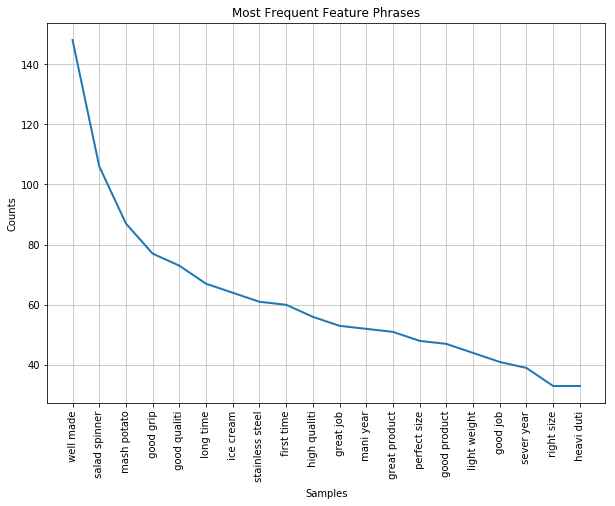

In [76]:
import matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))  # We want a bigger size plot
freqdist.plot(20, title = "Most Frequent Feature Phrases", cumulative = False)

Unlemmatize and unstem using the dictionary created earlier

In [42]:
import inflect

In [44]:
print(extracted[:10])

[' alreadi tri', ' quick pop', ' good recip', ' sweet dessert', ' fruit pop', ' dessert pop', ' pop recip', ' detail inform', ' differ type', ' decor fruit']


In [47]:
p = inflect.engine()
def replacewords(mc):
    newmc=[]
    for a in mc:
        newword="";found=False;
        for b in a[0].split():            
            for x in lem_word_mapping:
                #print(x)
                #print(b)
                if b==x:
                    found=True
                    sing=(lem_word_mapping[x] if p.singular_noun(lem_word_mapping[x])==False else p.singular_noun(lem_word_mapping[x]))
                    if newword=="":
                        newword = newword + sing
                    else:
                        newword = newword + " " +  sing
            if found==False:
                if newword=="":
                    newword = newword + b
                else:
                    newword = newword + " " +  b
                    #print(newword)
        newmc.append((newword,a[1]))
    return newmc

final = replacewords(most_common)

print("Top Feature Phrases:")
print(final[0])
print(final[:50])

Opinon phrases:
('well made', 148)
[('well made', 148), ('salad spinner', 106), ('mashed potato', 87), ('goodnes grip', 77), ('goodnes quality', 73), ('long time', 67), ('icing cream', 64), ('stainless steel', 61), ('first time', 60), ('high quality', 56), ('great job', 53), ('many year', 52), ('great product', 51), ('perfection size', 48), ('goodnes product', 47), ('light weighted', 44), ('goodnes job', 41), ('several year', 39), ('right size', 33), ('heavy duty', 33), ('soft serving', 32), ('goodnes thing', 31), ('ever use', 31), ('comfortable handle', 31), ('vegetable brushed', 30), ('little bit', 29), ('several time', 29), ('well designed', 29), ('frozen yogurt', 28), ('reason pricing', 27), ('hot watered', 26), ("n't use", 26), ('many time', 25), ('sharpnes edge', 25), ('dished brushed', 25), ('goodnes value', 24), ('never use', 24), ('ergonomic designed', 24), ('also use', 23), ('small amount', 23), ('highly recommendation', 23), ('goodnes size', 22), ('cold watered', 21), ('good

We'll find out the opinions corresponding to the most common features

In [85]:
def featuresInContext(item_arr, opinion_phrases, sentence_arr ):
    for item,support in sorted(item_arr, key=lambda item_support: item_support[1], reverse=True):
        count = 0
        print("------" + "Item > " + item[0] + "------")
        for phrase, freq in sorted(opinion_phrases, key = lambda phrase_freq: phrase_freq[1], reverse = True):
            pcount = 0
            if normalise(item[0]) in normalise(phrase):
                count+=1
                print("---" + "Phrase > " + phrase + "----")
                for l in sentence_arr:
                    if normalise(phrase) in normalise(l):
                        # print("Debug: " + l)
                        for b in zip(l.split(" ")[:-1], l.split(" ")[1:]):
                            #print(b[0]+" "+b[1])
                            if normalise(b[0])==normalise(item[0]):
                                print("---" + "examplex" + "----")
                                print(l.replace("'","").replace("]","").replace("[",""))
                                pcount+=1
                                break
                            elif (normalise(b[0])+" "+normalise(b[1]))==normalise(item[0]):
                                print("---" + "exampley" + "----")
                                print(l.replace("'","").replace("]","").replace("[",""))
                                pcount+=1
                                break
                        if pcount==3:
                            break                
            if count==3:
                break 
        
# sent_str = ""
# sent_str = sent_str.join(sent_fullreview)
# token_sentences = sent_tokenizer1.tokenize(sent_str)
# featuresInContext(items, final, sent_fullreview)

In [88]:
print(len(items))
items_few = items[:2]
print(len(items_few))
print(items_few)

76
2
[(('steel',), 0.015976087404658834), (('way',), 0.01860441146155432)]


In [89]:
featuresInContext(items_few, final, sent_fullreview)

------Item > way------
---Phrase > alway use----
---Phrase > great way----
---examplex----
Its a great way to top off the other four classes.didnt really care many of the cakes at all.
---examplex----
Great way to have an easy-to-make but fun treats for all sorts of occasions.- there are suggestions for bdays, sports, holidays, gifts...CONS:- You need to buy the molds or supplies to make any of special shapes so its an investment up front.
---examplex----
Great way to use up ripe bananas, and make banana split ice cream.Ive made 3 batches with my machine; here are my observations.
---Phrase > easy way----
---examplex----
My DH loves coffee ice cream but it is hard to find where we live so I have to make it for him and this is the easy way to do it.
---examplex----
It is awesome for ice cream, sorbet and slushy mixed adult beverages....mmmmmm.....cant wait for summer again!This is a delightfully easy way to make ice cream that tastes the way you want it to.
---examplex----
It doesnt hav